# Fine-tuning BERT for sentiment analysis

In [1]:
!pip install datasets
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data preprocessing

In [2]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [4]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

In [5]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

In [6]:
special = tokenizer.all_special_tokens
dict(zip(special, tokenizer.convert_tokens_to_ids(special)))

{'[UNK]': 100, '[SEP]': 102, '[PAD]': 0, '[CLS]': 101, '[MASK]': 103}

In [7]:
small_train_dataset[0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [8]:
print(small_train_dataset[0]["text"][:100])
print(small_train_dataset[0]["input_ids"][0])  # [CLS]
i = small_train_dataset[0]["input_ids"][8]
print(i, tokenizer.convert_ids_to_tokens(i))  # token with id `i`
print(small_train_dataset[0]["input_ids"][-10:])  # [PAD]

There is no relation at all between Fortier and Profiler but the fact that both are police series ab
101
3144 Fort
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Bert Fine-tuning

The architecture of BERT is the same as the encoder of a transformer network. It mainly consists of a series of self-attention layers (12 in case of the base model and 24 in the large model) combined with layer normalization and residual layers.

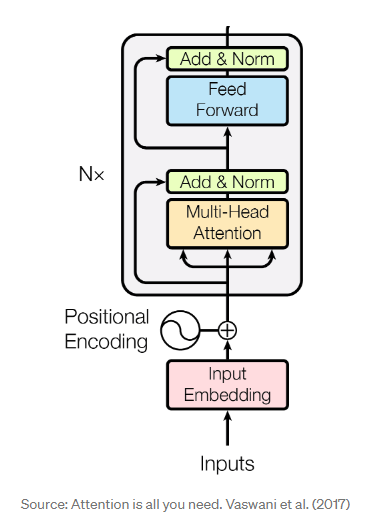


This network is pre-trained on large corpora on two main tasks:

1. Masked Language Model: Given an input sentence, some words are randomly (in the paper they choose 15% of the total words) replaced with a MASK token and the network is trained to predict these masked words.

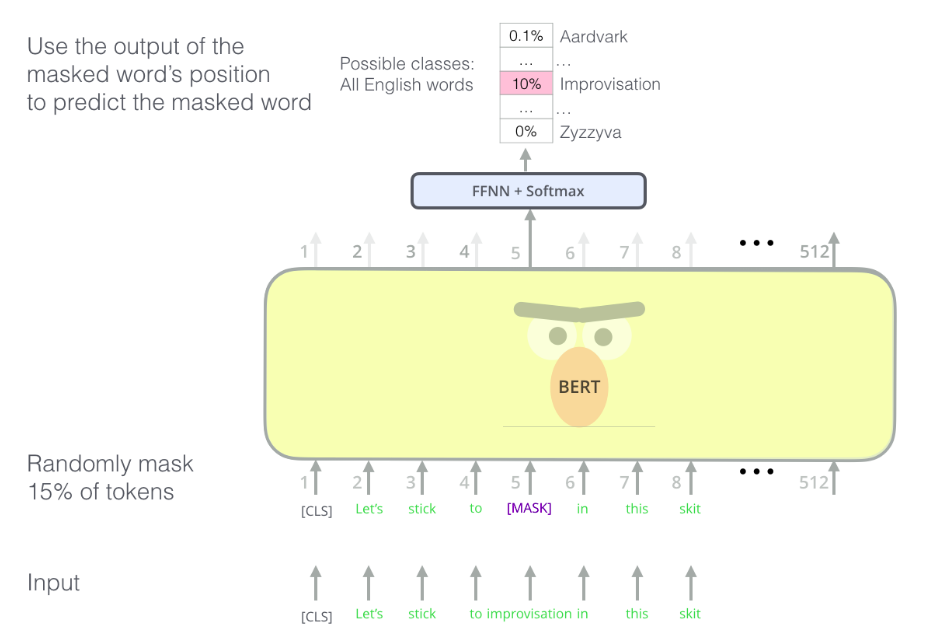


2. Next Sentence Prediction: BERT can also handle a pair of sequences as inputs. For these cases, the 2 sequences are separated by a [SEP] token. In addition to the masked LM Task, we also train BERT on the next sentence prediction problem, where given 2 sentences it needs to predict if the first sentence comes before second in the actual corpus.

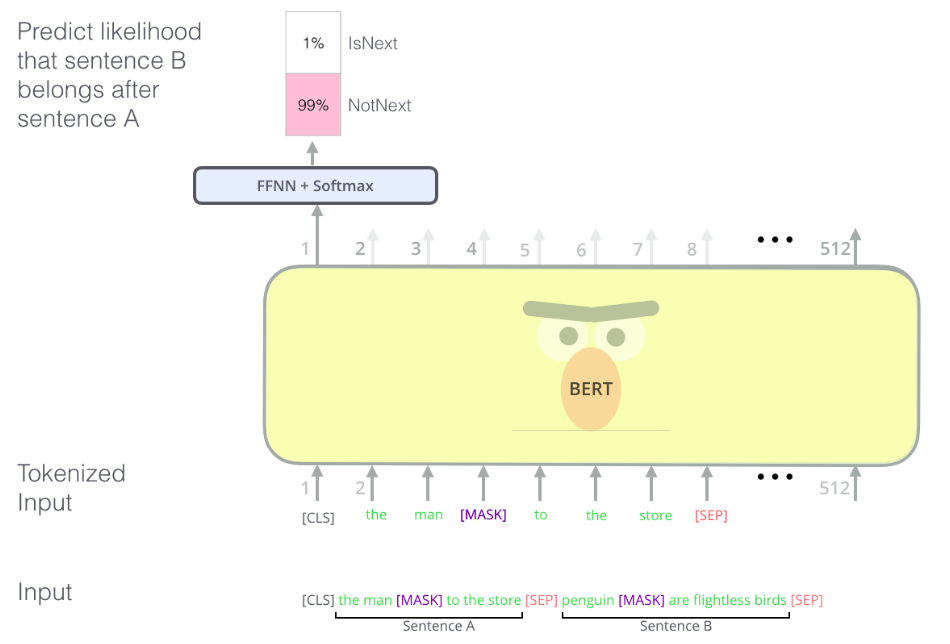

You may have noticed the [CLS] token in the figure, it is basically added to the beginning of each sequence (or pair of sequences) and is given the responsibility of sequence level classification. That’s why we used the embeddings of [CLS] token to predict if sentence A comes before B in the next sentence prediction task.

After BERT is trained on these 2 tasks, the learned model can be then used as a feature extractor for different NLP problems, where we can either keep the learned weights fixed and just learn the newly added task-specific layers or fine-tune the pre-trained layers too.

In [9]:
import torch
from torch.utils.data import DataLoader

from transformers import BertModel, BertTokenizer

def to_tensors(x):
    return (torch.tensor(x['input_ids']), torch.tensor(x['attention_mask']), torch.tensor(x['label']))

small_train_dataset_tensors = [to_tensors(x) for x in small_train_dataset]
small_eval_dataset_tensors = [to_tensors(x) for x in small_eval_dataset]

train_loader = DataLoader(small_train_dataset_tensors, batch_size=64)
val_loader = DataLoader(small_eval_dataset_tensors, batch_size=64)

In [10]:
import torch
import torch.nn as nn
from transformers import BertModel

class SentimentClassifier(nn.Module):

    def __init__(self, freeze_bert = True):
        super(SentimentClassifier, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        #Freeze bert layers
        if freeze_bert:
            for p in self.bert_layer.parameters():
                #TODO: freeze bert training weights
                p.requires_grad = False

        #Classification layer
        self.cls_layer = nn.Linear(768, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        output = self.bert_layer(seq, attention_mask=attn_masks)
        # task: get last hidden state from output
        cont_reps = output.last_hidden_state
        
        #Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(cls_rep)

        return logits

In [11]:
net = SentimentClassifier(freeze_bert=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=2e-5)

In [13]:
def get_accuracy_from_logits(logits, labels):
    #Get a tensor of shape [B, 1, 1] with probabilities that the sentiment is positive
    probs = torch.sigmoid(logits.unsqueeze(-1))
    #Convert probabilities to predictions, 1 being positive and 0 being negative
    soft_probs = (probs > 0.5).long()
    #Check which predictions are the same as the ground truth and calculate the accuracy
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc

In [14]:
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train(net, criterion, optimizer, train_loader, val_loader):
    net = net.to(device)
    net.train()

    for epoch in range(5):
        for iteration, (seq, attn_masks, labels) in enumerate(tqdm((train_loader))):
            optimizer.zero_grad()
            seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)

            logits = net(seq,attn_masks) # task: model forward pass
            loss = criterion(logits.squeeze(-1), labels.float())
            loss.backward()
            optimizer.step()

        acc = get_accuracy_from_logits(logits, labels)
        print("Iteration {} of epoch {} complete. Loss : {} Accuracy : {}".format(iteration + 1, epoch + 1, loss.item(), acc))

In [15]:
train(net, criterion, optimizer, train_loader, val_loader)

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 16 of epoch 1 complete. Loss : 0.7085825800895691 Accuracy : 0.4000000059604645


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 16 of epoch 2 complete. Loss : 0.6974217295646667 Accuracy : 0.42500001192092896


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 16 of epoch 3 complete. Loss : 0.7035335898399353 Accuracy : 0.32500001788139343


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 16 of epoch 4 complete. Loss : 0.6926196217536926 Accuracy : 0.4749999940395355


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 16 of epoch 5 complete. Loss : 0.7037178874015808 Accuracy : 0.3499999940395355


In [18]:
from datasets import load_metric

metric = load_metric("accuracy")
net.eval()

for seq, attn_masks, labels in val_loader:
    seq, attn_masks, labels = seq.to(device), attn_masks.to(device), labels.to(device)
    with torch.no_grad():
        logits = net(seq, attn_masks)

    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=labels)  # task: fill parameters

metric.compute()

{'accuracy': 0.512}

In [29]:
def infer(net, text):
     # task: implement inference
     #examples = 
     token_text = tokenizer(text, padding="max_length", truncation=True)
     seq_tensr = torch.tensor(token_text['input_ids'])
     att_mask_tensr = torch.tensor(token_text['attention_mask'])

     seq_tensr = torch.unsqueeze(seq_tensr,0)
     att_mask_tensr = torch.unsqueeze(att_mask_tensr,0)
     
     seq_tensr, att_mask_tensr = seq_tensr.to(device), att_mask_tensr.to(device)
     with torch.no_grad():
        logits = net(seq_tensr, att_mask_tensr)

     label = torch.argmax(logits, dim=-1)
     return label
    
text = "your positive or negative text"
label = infer(net, text)
print(label)

tensor([0], device='cuda:0')


## BertForSequenceClassification Fine-tuning

In [30]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [31]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer")

In [32]:
# task: change the number of epochs to 5
training_args.num_train_epochs = 5

In [38]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, train_dataset=small_train_dataset, eval_dataset=small_eval_dataset)

In [40]:
for param in model.bert.parameters():
    # task: freeze bert training weights
    param.requires_grad = True

In [41]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 625


Step,Training Loss
500,0.239300


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=625, training_loss=0.19228026609420776, metrics={'train_runtime': 484.2783, 'train_samples_per_second': 10.325, 'train_steps_per_second': 1.291, 'total_flos': 1422904587386880.0, 'train_loss': 0.19228026609420776, 'epoch': 5.0})

In [42]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [43]:
# task: achieve 80% accuracy, you may also try unfreeze the bert parameters

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'eval_loss': 0.769340455532074,
 'eval_accuracy': 0.877,
 'eval_runtime': 33.5061,
 'eval_samples_per_second': 29.845,
 'eval_steps_per_second': 3.731}

Links

[Painless Fine-Tuning of BERT in Pytorch](https://medium.com/swlh/painless-fine-tuning-of-bert-in-pytorch-b91c14912caa)

[Fine-tuning BERT by Hugging Face](https://huggingface.co/docs/transformers/v4.16.2/en/training)